# 0. Setup

## General

In [50]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

from catboost import CatBoostRegressor
from tabpfn_time_series import TimeSeriesDataFrame, TabPFNTimeSeriesPredictor, TabPFNMode
from tabpfn import TabPFNRegressor
import statsmodels

RANDOM_STATE = 42

In [51]:
# Chart style settings
import matplotlib.style as style
style.use({
    'font.family': 'Monospace',
    'font.size': 10,
})

In [52]:
# Data folders
from pathlib import Path

raw_data_dir = Path.cwd().parent / "data" / "raw"
raw_data_dir.mkdir(parents=True, exist_ok=True)

processed_data_dir = Path.cwd().parent / "data" / "processed"
processed_data_dir.mkdir(parents=True, exist_ok=True)

In [53]:
# Spans for time series charts
def add_event_spans(ax):
    return {
        'brexit': ax.axvspan(pd.Timestamp('2016-06'), pd.Timestamp('2017-06'),
                             color="#4B9CD3", alpha=0.2, hatch='....', label='Post Brexit volatility'),
        'covid1': ax.axvspan(pd.Timestamp('2020-03'), pd.Timestamp('2020-05'),
                             color="#FF6B6B", alpha=0.2, hatch='....', label='1st COVID lock-down'),
        'covid2': ax.axvspan(pd.Timestamp('2020-11'), pd.Timestamp('2020-12'),
                             color="#FF6B6B", alpha=0.2, hatch='....', label='2nd COVID lock-down'),
        'covid3': ax.axvspan(pd.Timestamp('2021-01'), pd.Timestamp('2021-04'),
                             color="#FF6B6B", alpha=0.2, hatch='....', label='3rd COVID lock-down'),
        'energy': ax.axvspan(pd.Timestamp('2021-10'), pd.Timestamp('2022-10'),
                             color="#FFD166", alpha=0.2, hatch='....', label='Energy-price crisis')
    }

## Data Load

In [54]:
df_features = pd.read_pickle('../data/processed/dataset_with_features.pkl')

H = 36                       # Horizon for TabPFN
train_end = df_features.index[-H]
y_te = df_features.loc[train_end:]['target']

In [55]:
"""
with open('../data/processed/splits.pkl', 'rb') as f:
    D = pickle.load(f)
X_tr, y_tr = D['X_train'], D['y_train']
X_ca, y_ca = D['X_cal'], D['y_cal']
X_te, y_te = D['X_test'], D['y_test']
print('Shapes:', X_tr.shape, X_ca.shape, X_te.shape)

df = pd.read_csv('../data/processed/uk_final.csv',
                 parse_dates=['date'], index_col='date').asfreq('M')

X_tr.info()
"""

"\nwith open('../data/processed/splits.pkl', 'rb') as f:\n    D = pickle.load(f)\nX_tr, y_tr = D['X_train'], D['y_train']\nX_ca, y_ca = D['X_cal'], D['y_cal']\nX_te, y_te = D['X_test'], D['y_test']\nprint('Shapes:', X_tr.shape, X_ca.shape, X_te.shape)\n\ndf = pd.read_csv('../data/processed/uk_final.csv',\n                 parse_dates=['date'], index_col='date').asfreq('M')\n\nX_tr.info()\n"

# 1. Model Wrappers

## CatBoostRegressor

In [7]:
# Wrapper for CatBoostRegressor
class CatBoostWrapper:

    def __init__(self, **catboost_params):
        default_params = {
            'iterations': 1000,
            'learning_rate': 0.1,
            'depth': 6,
            'random_seed': 42,
            'verbose': False,
            'early_stopping_rounds': 50
        }

        default_params.update(catboost_params)

        self.model = CatBoostRegressor(**default_params)
        self.is_fitted = False
        self.feature_names = None
        self.feature_names_ = None
        self.predictions = {}

    def fit(self, X_train, y_train, X_val=None, y_val=None, categorical_features=None):
        if isinstance(X_train, pd.DataFrame):
            self.feature_names = X_train.columns.tolist()

        # Identify categorical features automatically if not specified
        if categorical_features is None and isinstance(X_train, pd.DataFrame):
            categorical_features = []
            for col in X_train.columns:
                if X_train[col].dtype in ['object', 'category', 'bool']:
                    categorical_features.append(col)

        eval_set = None
        if X_val is not None and y_val is not None:
            eval_set = [(X_val, y_val)]

        self.model.fit(
            X_train,
            y_train,
            eval_set=eval_set,
            cat_features=categorical_features,
            use_best_model=True if eval_set else False
        )

        self.feature_names_ = self.model.feature_names_

        self.is_fitted = True
        return self

    def get_feature_importance(self):
        if not self.is_fitted:
            raise ValueError("Model must be fitted before getting feature importance")

        importance = self.model.get_feature_importance()
        feature_names = self.model.feature_names_

        return (
            pd.DataFrame({'feature': feature_names, 'importance': importance})
            .sort_values('importance', ascending=False)
            .reset_index(drop=True)
        )

    def predict(self, X, dataset_name='test'):
        if not self.is_fitted:
            raise ValueError("Model must be fitted before making predictions")

        predictions = self.model.predict(X)
        self.predictions[dataset_name] = predictions
        return predictions

    def conformal_error(self, X_cal, y_cal):
        if not self.is_fitted:
            raise ValueError("Model must be fitted before calculating conformal errors")

        # Use a different dataset name to avoid overwriting other predictions
        cal_predictions = self.predict(X_cal, dataset_name='calibration_conformal')
        return np.abs(y_cal - cal_predictions)

## TabPFN_TS

In [8]:
from scipy.stats import norm


class TabPFNTimeSeriesWrapper:
    """
    Rolling-window–friendly wrapper for TabPFN-Time-Series.
    Designed to work inside a rolling-window conformal loop.
    """

    def __init__(self, **tabpfn_params):
        allowed = {"N_ensemble_configurations", "seed"}
        kwargs = {k: v for k, v in tabpfn_params.items() if k in allowed}
        kwargs.setdefault("N_ensemble_configurations", 16)
        kwargs.setdefault("seed", 42)

        self.model = TabPFNTimeSeriesPredictor(**kwargs)
        self.is_fitted = False

    # ------------------------------------------------------------------
    # 1. Fit on an arbitrary slice (no global state)
    # ------------------------------------------------------------------
    def fit_on_slice(self, slice_df: pd.DataFrame, target_col: str = "target"):
        """
        slice_df : DataFrame with DatetimeIndex containing all features + *target_col*
        """
        if not isinstance(slice_df.index, pd.DatetimeIndex):
            raise ValueError("slice_df must have a DatetimeIndex")

        self.feature_names = slice_df.columns.tolist()
        self.feature_names.remove(target_col)

        # Build TimeSeriesDataFrame
        ts_df = TimeSeriesDataFrame(slice_df, time_col=slice_df.index.name or "timestamp")

        # Fit
        self.model.fit(ts_df)
        self.is_fitted = True
        return self

    # ------------------------------------------------------------------
    # 2. One-step forecast (returns scalar)
    # ------------------------------------------------------------------
    def forecast_1_step(self, slice_df: pd.DataFrame, target_col: str = "target"):
        """
        slice_df : DataFrame with DatetimeIndex up to t-1
        Returns   : scalar prediction for step t
        """
        if not self.is_fitted:
            raise ValueError("Model must be fitted")

        ts_df = TimeSeriesDataFrame(slice_df, time_col=slice_df.index.name or "timestamp")
        pred = self.model.forecast(steps_ahead=1).iloc[-1]
        return float(pred)

    # ------------------------------------------------------------------
    # 3. Calibration residuals
    # ------------------------------------------------------------------
    def conformal_error(self, slice_df: pd.DataFrame, target_col: str = "target"):
        """
        slice_df : DataFrame used as the calibration window
        Returns   : 1-D array of absolute residuals
        """
        if not self.is_fitted:
            raise ValueError("Model must be fitted")

        ts_df = TimeSeriesDataFrame(slice_df, time_col=slice_df.index.name or "timestamp")
        pred = self.model.forecast(steps_ahead=len(slice_df))
        return np.abs(slice_df[target_col].values - pred.values)

    # ------------------------------------------------------------------
    # 4. Simple info
    # ------------------------------------------------------------------
    def get_model_info(self):
        return {
            "model_type": "TabPFN Time Series",
            "mode": str(self.mode),
            "is_fitted": self.is_fitted,
            "feature_names": self.feature_names or [],
            "ensemble_size": getattr(self.model, "N_ensemble_configurations", "Unknown"),
            "device": getattr(self.model, "device", "Unknown")
        }

## SARIMAX

# 2. Fit on Train

## Catboost

In [ ]:
# TTS


In [ ]:
# Hyper-parameter grid
param_grid = {
    'iterations': [300, 500],
    'depth': [3, 4],
    'learning_rate': [0.05, 0.1],
}

# Time-series CV (5 folds, gap = 0)
tscv = TimeSeriesSplit(n_splits=5)

# One CV run
def cv_score(params, X, y, cv=tscv):
    maes = []
    for train_idx, val_idx in cv.split(X):
        X_fold_tr, y_fold_tr = X.iloc[train_idx], y.iloc[train_idx]
        X_fold_val, y_fold_val = X.iloc[val_idx], y.iloc[val_idx]

        model = CatBoostWrapper(**params)
        model.fit(X_fold_tr, y_fold_tr)
        pred = model.predict(X_fold_val)
        maes.append(mean_absolute_error(y_fold_val, pred))
    return np.mean(maes)

# Grid search
best_params, best_mae = None, np.inf
for p in itertools.product(*param_grid.values()):
    params = dict(zip(param_grid.keys(), p))
    mae = cv_score(params, X_tr, y_tr)
    if mae < best_mae:
        best_mae, best_params = mae, params

print("Best CV MAE:", best_mae)
print("Best params:", best_params)

Best CV MAE: 1.975179008843868
Best params: {'iterations': 500, 'depth': 4, 'learning_rate': 0.1}


In [ ]:
# CatBoost on best parameters
cb_wrapper = CatBoostWrapper(**best_params)
cb_wrapper.fit(X_tr, y_tr)
importance_df = cb_wrapper.get_feature_importance()
importance_df

,feature,importance
0,lag_1,61.867757
1,CPI_t-1,25.924628
2,Consumer_conf_diff_1,7.551820
3,is_outlier,4.655795
4,cp_85,0.000000


## TabPFN

# 3. Calibration

## CatBoost

In [ ]:
# ---------- rolling-window conformal for CatBoost ----------
HORIZON = len(y_te)               # 42 steps
q_hats = np.empty(HORIZON)       # one q_hat per origin
y_pred = np.empty(HORIZON)

for i, origin in enumerate(y_te.index):
    # 1. data up to t-1 (origin-1 month)
    mask = df.index < origin
    history = df.loc[mask]

    # 2. rolling calibration window: last 12 months of history
    cal_slice = history.tail(12)
    train_slice = history.iloc[:-12]

    # 3. fit model on train_slice
    model = CatBoostWrapper(**best_params)
    model.fit(train_slice.drop(columns=['Retail_sales_index']),
              train_slice['Retail_sales_index'])

    # 4. compute q_hat on cal_slice
    resids = model.conformal_error(
        cal_slice.drop(columns=['Retail_sales_index']),
        cal_slice['Retail_sales_index']
    )
    q_hats[i] = np.quantile(resids, 0.90)

    # 5. one-step forecast for origin
    y_pred[i] = model.predict(X_te.iloc[[i]])[0]   # single-row X

# ---------- build final PI ----------
lower = y_pred - q_hats
upper = y_pred + q_hats

cb_forecast_df = pd.DataFrame({
    'pred': y_pred,
    'lower': lower,
    'upper': upper
}, index=y_te.index)

## TabPFN

In [57]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124 entries, 2015-02-28 to 2025-05-31
Freq: M
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   target                      124 non-null    float64
 1   cp_85_t-1                   124 non-null    float64
 2   is_outlier_t-1              124 non-null    bool   
 3   lag_1                       124 non-null    float64
 4   CPI_t-1                     124 non-null    float64
 5   CPI_diff_1_shift            124 non-null    float64
 6   Consumer_conf_diff_1_shift  124 non-null    float64
dtypes: bool(1), float64(6)
memory usage: 6.9 KB


In [70]:
# MAIN
from tabpfn_time_series import TimeSeriesDataFrame, TabPFNTimeSeriesPredictor

# Initialize predictor once (zero-shot, no training needed)
predictor = TabPFNTimeSeriesPredictor()

HORIZON = len(y_te)
tab_pred = np.empty(HORIZON)
tab_q_hat = np.empty(HORIZON)

# Load full dataset with new format
full_df = pd.read_csv('../data/processed/uk_final_formatted.csv',
                      parse_dates=['timestamp'], index_col='timestamp').asfreq('M')

assert 'target' in full_df.columns, "Target column not found in data"


def to_tsdf(df_slice: pd.DataFrame,
            target_col: str = "target",
            fill_value: float = 0.0) -> TimeSeriesDataFrame:
    """
    Build a TimeSeriesDataFrame with consistent columns.
    IMPORTANT: TabPFN requires 'target' column to always exist, even if NaN.
    """
    df = df_slice.copy()

    # Ensure feature columns exist - use the same approach as your original code
    # feature_cols = ["cp_85", "is_outlier", "lag_1", "CPI_t-1", "Consumer_conf_diff_1"]
    feature_cols = [col for col in full_df.columns if col != 'target']

    for col in feature_cols:
        if col not in df.columns:
            # Use appropriate fill value based on dtype in full_df
            if col in full_df.columns:
                if full_df[col].dtype == 'bool':
                    df[col] = False
                else:
                    df[col] = fill_value
            else:
                df[col] = fill_value

    # CRITICAL: Target column must always exist
    if target_col not in df.columns:
        df[target_col] = np.nan  # Fill with NaN for test data

    # Add required metadata
    df["item_id"] = 0  # Single time series
    df["timestamp"] = df.index

    return TimeSeriesDataFrame(
        df,
        id_column="item_id",
        timestamp_column="timestamp"
    )


# Rolling window evaluation
for i, origin in enumerate(y_te.index):
    history = full_df[full_df.index < origin]

    # Split into train and calibration
    train_slice = history.iloc[:-18]
    cal_slice = history.iloc[-18:]

    # Build TimeSeriesDataFrames for training
    train_ts = to_tsdf(train_slice)

    # For calibration: create a copy without target values for prediction
    cal_slice_for_pred = cal_slice.copy()
    cal_slice_for_pred['target'] = np.nan  # Set target to NaN for prediction
    cal_ts = to_tsdf(cal_slice_for_pred)

    # Calibration: get predictions for calibration period
    cal_predictions = predictor.predict(train_ts, cal_ts)

    # Extract predictions - TabPFN returns a DataFrame
    if isinstance(cal_predictions, pd.DataFrame):
        # Get the prediction values (usually in first column)
        cal_pred_values = cal_predictions.iloc[:, 0].values
    else:
        cal_pred_values = np.array(cal_predictions).flatten()

    # Ensure we have the right number of predictions
    if len(cal_pred_values) != len(cal_slice):
        # Take the last predictions if we have more
        cal_pred_values = cal_pred_values[-len(cal_slice):]

    # Compute calibration residuals
    cal_actuals = cal_slice['target'].values
    residuals = np.abs(cal_actuals - cal_pred_values)

    # Compute conformal quantile (90% coverage)
    alpha = 0.07
    tab_q_hat[i] = np.quantile(residuals, 1 - alpha)

    # OPTIONAL: Apply inflation factor to q_hat - makes interval much wider
    # This is a common practice to adjust for variability in residuals
    # Here we use the 95th percentile divided by the 90th percentile as inflation factor
    # inflation = np.percentile(residuals, 95) / np.percentile(residuals, 90)
    # tab_q_hat[i] *= inflation

    # Prediction: use full history to predict next point
    full_train_ts = to_tsdf(history)

    # Create test frame for one-step-ahead prediction
    # Create a DataFrame with the future timestamp
    future_df = pd.DataFrame(index=pd.date_range(origin, periods=1, freq='M'))

    # Copy last known feature values if available
    if len(history) > 0:
        feature_cols = [col for col in full_df.columns if col != 'target']
        for col in feature_cols:
            if col in history.columns:
                if col == 'lag_1':
                    # lag_1 should be the last known target value
                    future_df[col] = history['target'].iloc[-1]
                else:
                    # Copy the last value for other features
                    future_df[col] = history[col].iloc[-1]

    # Add lag_1 as the last known target value
    if 'target' in history.columns:
        future_df['lag_1'] = history['target'].iloc[-1]

    # Create test TimeSeriesDataFrame with NaN target
    future_df['target'] = np.nan
    test_ts = to_tsdf(future_df)

    # Make prediction
    test_predictions = predictor.predict(full_train_ts, test_ts)

    # Extract point prediction
    if isinstance(test_predictions, pd.DataFrame):
        tab_pred[i] = test_predictions.iloc[0, 0]
    else:
        tab_pred[i] = float(test_predictions)

# Construct prediction intervals
tab_lower = tab_pred - tab_q_hat
tab_upper = tab_pred + tab_q_hat

tb_forecast_df = pd.DataFrame({
    'pred': tab_pred,
    'lower': tab_lower,
    'upper': tab_upper,
    'q_hat': tab_q_hat  # Store for analysis
}, index=y_te.index)

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 608.05it/s]


In [71]:
# Compute coverage if actual values are available
if 'y_te' in locals():
    actual_values = y_te.values
    coverage = np.mean((actual_values >= tab_lower) & (actual_values <= tab_upper))
    print(f"Empirical coverage: {coverage:.2%} (target: ) {1 - alpha:.2%}")

    # Additional metrics
    mean_interval_width = np.mean(tab_upper - tab_lower)
    print(f"Mean interval width: {mean_interval_width:.2f}")

Empirical coverage: 97.22% (target: ) 93.00%
Mean interval width: 10.44


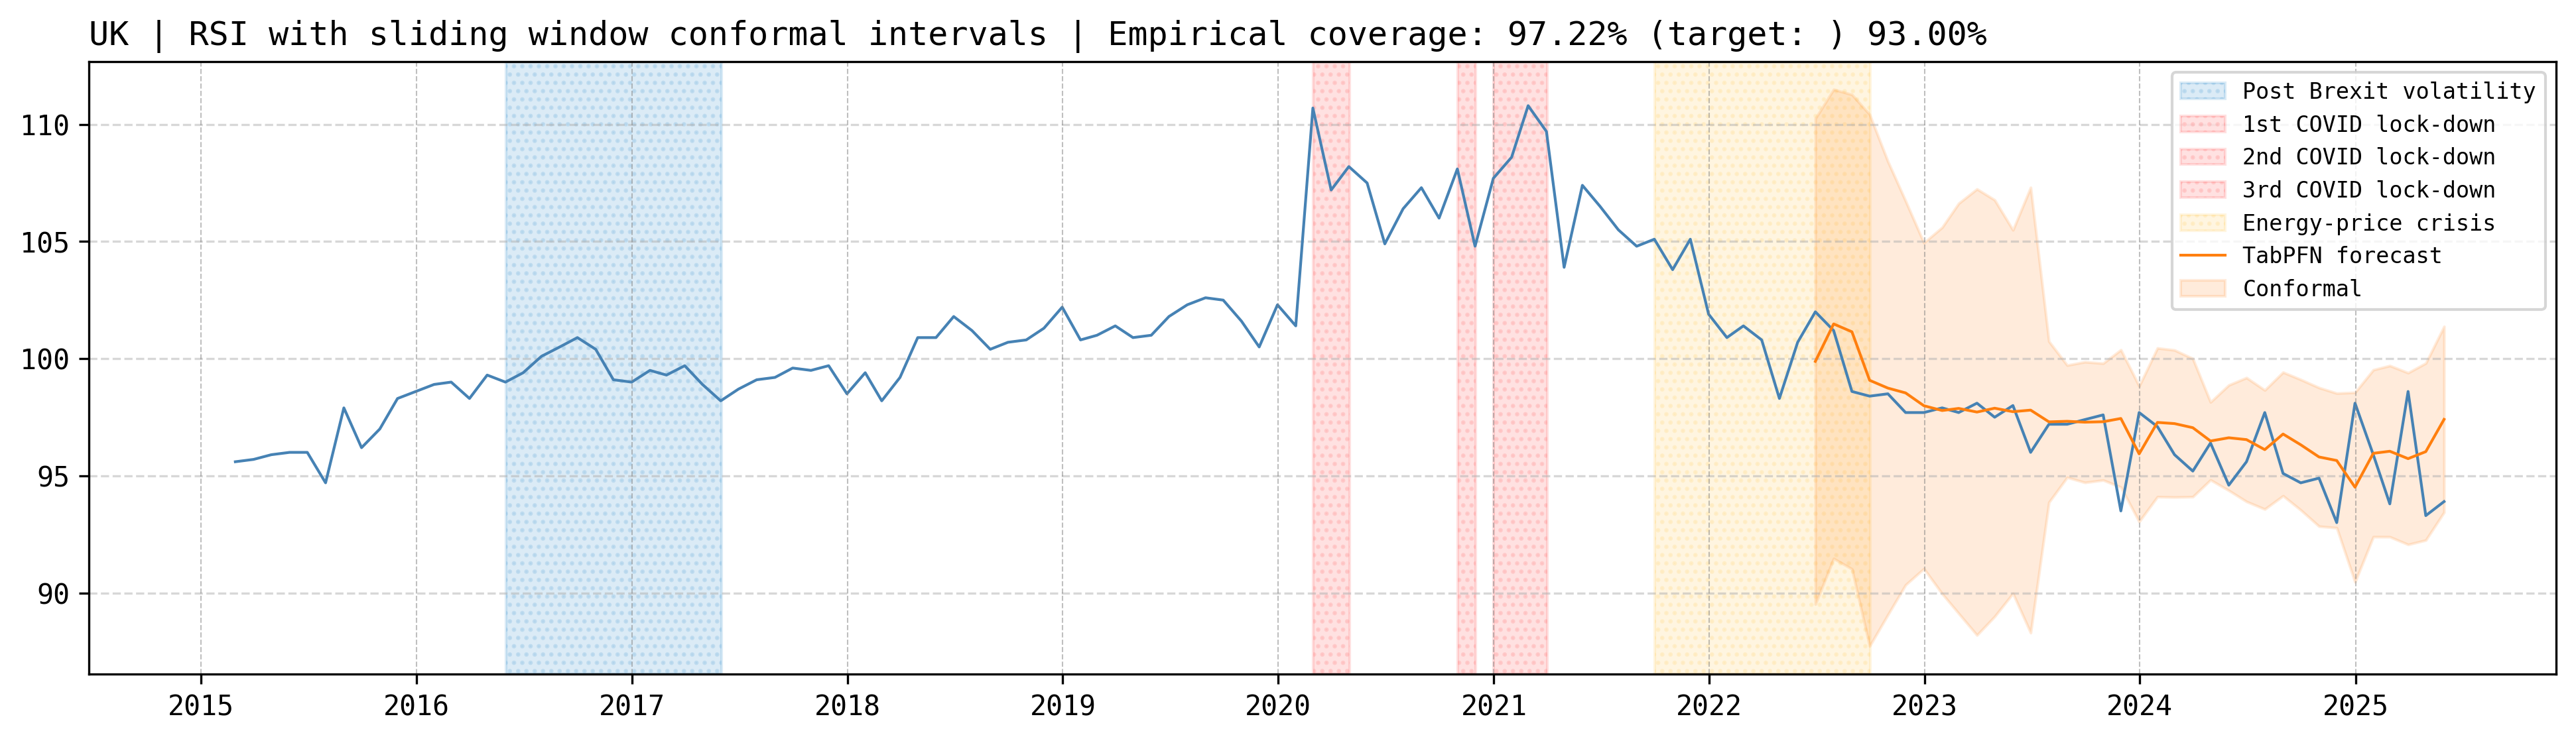

In [72]:
plt.figure(figsize=(16, 4), dpi=300)

# Main RSI plot
ax = sns.lineplot(data=full_df, x='timestamp', y='target', linewidth=1, color='steelblue')

ax.set_xticks([pd.Timestamp(f'{year}-01-01') for year in range(2015, 2026)])
ax.set_xticklabels([str(year) for year in range(2015, 2026)])
for tick in ax.get_xticks():
    ax.axvline(x=tick, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Spans for significant events
event_spans = add_event_spans(ax)

# Forecast line and PI
sns.lineplot(x=tb_forecast_df.index, y=tb_forecast_df['pred'], ax=ax, color='tab:orange', linewidth=1, label='TabPFN forecast')
ax.fill_between(tb_forecast_df.index, tb_forecast_df['lower'], tb_forecast_df['upper'], color='tab:orange', alpha=0.15, label='Conformal')

ax.legend(fontsize=8)

plt.xlabel('')
plt.ylabel('')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.title(f'UK | RSI with sliding window conformal intervals | Empirical coverage: {coverage:.2%} (target: ) {1 - alpha:.2%}', loc='left')
plt.show()

In [ ]:
# ORIGINAL WORKING VERSION

# ---------- rolling-window conformal for TabPFN Time Series ----------
from tabpfn_time_series import TimeSeriesDataFrame, TabPFNTimeSeriesPredictor

HORIZON = len(y_te)
tab_pred = np.empty(HORIZON)
tab_q_hat = np.empty(HORIZON)

full_df = pd.read_csv('../data/processed/uk_final.csv',
                      parse_dates=['date'], index_col='date').asfreq('M')
full_df['target'] = full_df['Retail_sales_index']


def to_tsdf(df_slice: pd.DataFrame,
            target_col: str = "target",
            fill_value: float = 0.0) -> TimeSeriesDataFrame:
    """
    Build a TimeSeriesDataFrame with consistent columns.
    """
    df = df_slice.copy()

    # ensure the five feature columns exist (order must match training slice)
    for col in ["cp_85", "is_outlier", "lag_1", "CPI_t-1", "Consumer_conf_diff_1"]:
        if col not in df.columns:
            df[col] = fill_value   # dummy placeholder

    if target_col not in df.columns:
        df[target_col] = np.nan

    df["item_id"] = 0
    df["timestamp"] = df.index
    return TimeSeriesDataFrame(df,
                               id_column="item_id",
                               timestamp_column="timestamp")


for i, origin in enumerate(y_te.index):
    history = full_df[full_df.index < origin]

    # rolling split
    train_slice = history.iloc[:-12]
    cal_slice = history.tail(12)

    # build TabPFN TimeSeriesDataFrame objects
    train_ts = to_tsdf(train_slice)
    cal_ts = to_tsdf(cal_slice)

    predictor = TabPFNTimeSeriesPredictor()

    # 1-step ahead on calibration slice
    ts_cal = to_tsdf(cal_slice, target_col='target')
    cal_pred = predictor.predict(train_ts, ts_cal).iloc[-1, 0]
    residuals = np.abs(cal_slice['target'].values - cal_pred)
    tab_q_hat[i] = np.quantile(residuals, 0.90)

    # 1-step ahead on full history
    full_ts = to_tsdf(full_df[full_df.index < origin].drop(columns=['Retail_sales_index']))
    # create dummy test frame with one future timestamp
    future_idx = pd.date_range(origin, periods=1, freq='M')
    future_df = pd.DataFrame(index=pd.date_range(origin, periods=1, freq="M"))
    test_ts = to_tsdf(future_df)
    tab_pred[i] = predictor.predict(full_ts, test_ts).iloc[-1, 0]

tab_lower = tab_pred - tab_q_hat
tab_upper = tab_pred + tab_q_hat

tb_forecast_df = pd.DataFrame({
    'pred': tab_pred,
    'lower': tab_lower,
    'upper': tab_upper
}, index=y_te.index)

# 4. Test Forecast & Intervals

# 5. Evaluation and Visualization

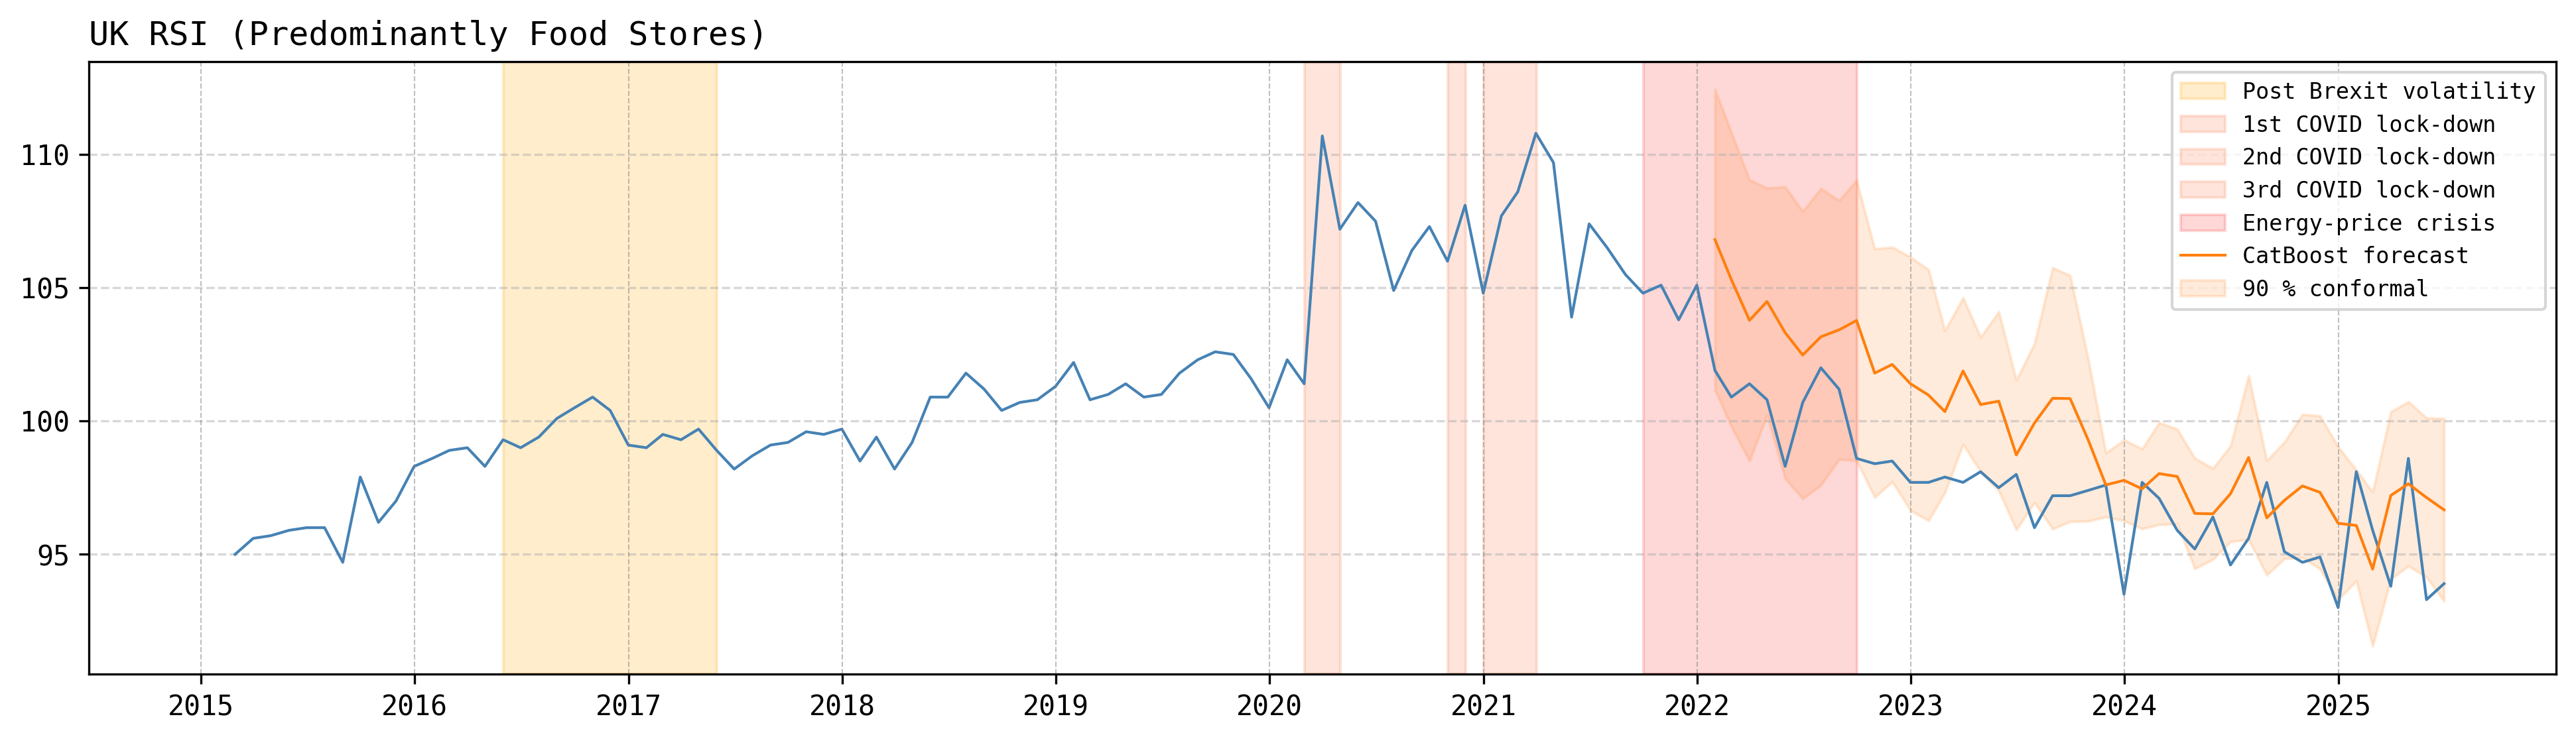

In [ ]:
plt.figure(figsize=(16, 4), dpi=300)
ax = sns.lineplot(data=df, x='date', y='Retail_sales_index', linewidth=1, color='steelblue')

ax.set_xticks([pd.Timestamp(f'{year}-01-01') for year in range(2015, 2026)])
ax.set_xticklabels([str(year) for year in range(2015, 2026)])
for tick in ax.get_xticks():
    ax.axvline(x=tick, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Spans for significant events
event_spans = add_event_spans(ax)

# Forecast line and PI
sns.lineplot(x=cb_forecast_df.index, y=cb_forecast_df['pred'],
             ax=ax, color='tab:orange', linewidth=1, label='CatBoost forecast')

ax.fill_between(cb_forecast_df.index,
                cb_forecast_df['lower'],
                cb_forecast_df['upper'],
                color='tab:orange', alpha=0.15, label='90 % conformal')

ax.legend(fontsize=8)

plt.xlabel('')
plt.ylabel('')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.title('UK RSI (Predominantly Food Stores)', loc='left')
plt.show()

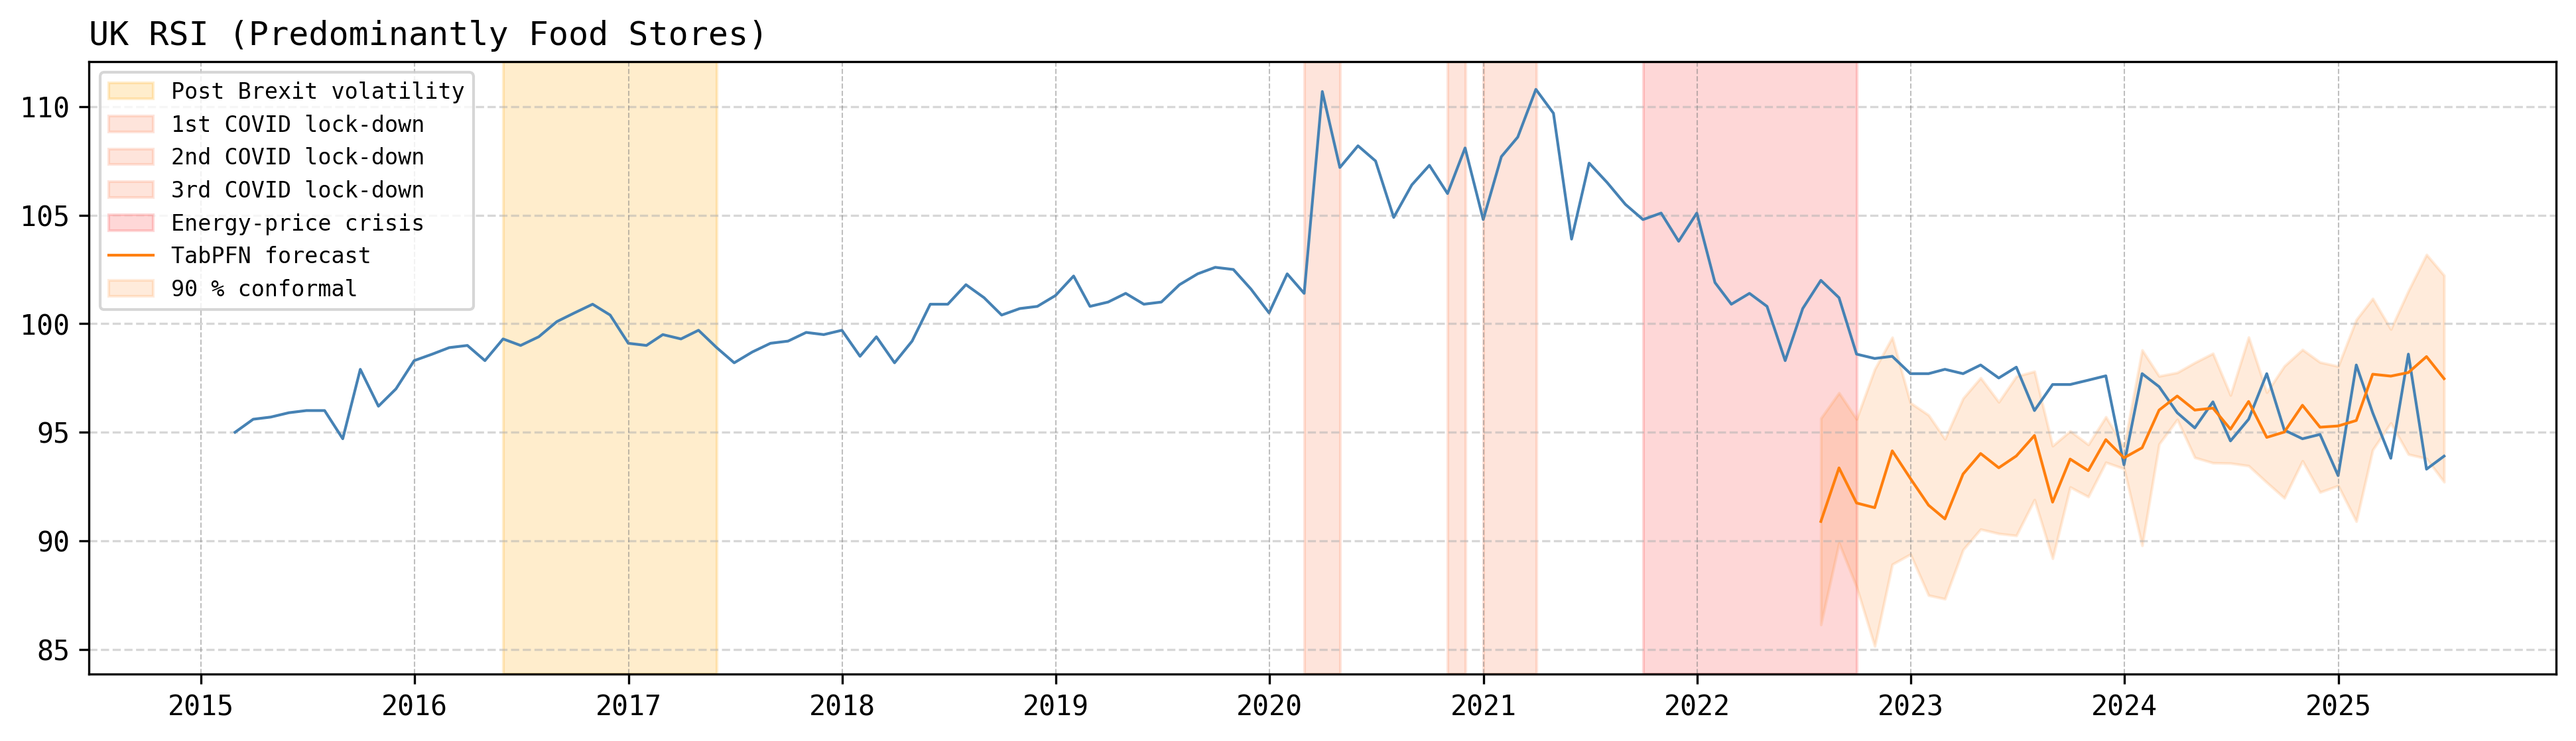

In [55]:
plt.figure(figsize=(16, 4), dpi=300)

# Main RSI plot
ax = sns.lineplot(data=df_features, x='timestamp', y='target', linewidth=1, color='steelblue')

ax.set_xticks([pd.Timestamp(f'{year}-01-01') for year in range(2015, 2026)])
ax.set_xticklabels([str(year) for year in range(2015, 2026)])
for tick in ax.get_xticks():
    ax.axvline(x=tick, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Spans for significant events
event_spans = add_event_spans(ax)

# Forecast line and PI
sns.lineplot(x=tb_forecast_df.index, y=tb_forecast_df['pred'], ax=ax, color='tab:orange', linewidth=1, label='TabPFN forecast')
ax.fill_between(tb_forecast_df.index, tb_forecast_df['lower'], tb_forecast_df['upper'], color='tab:orange', alpha=0.15, label='90 % conformal')

ax.legend(fontsize=8)

plt.xlabel('')
plt.ylabel('')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.title('UK RSI (Predominantly Food Stores)', loc='left')
plt.show()